In [43]:
##Load packages

import pandas as pd
import numpy as np
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt



In [44]:
#Load pre-processed datasets

vessels = pd.read_csv("Vesselposition_data_20-24Aug2025.csv").rename(columns={"upload-timestamp": "timestamp"}).drop(columns=["stale_since"])
weather = pd.read_csv("SAIL_Amsterdam_10min_Weather_2025-08-20_to_2025-08-24.csv")
sensors_location = pd.read_csv("sensor-location.xlsx - Sheet1.csv", ).rename(columns={"Objectnummer": "sensor_id"})
sensors = pd.read_csv("sensordata_SAIL2025.csv", parse_dates=["timestamp"])


C:\Users\Abel Arts\AppData\Local\Temp\ipykernel_26504\3964317749.py:3: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  vessels = pd.read_csv("Vesselposition_data_20-24Aug2025.csv").rename(columns={"upload-timestamp": "timestamp"}).drop(columns=["stale_since"])


In [53]:
#Mutations sensor information

#Replace , by r . so it can be used in calculations
sensors_location["Effectieve breedte"] = (
    sensors_location["Effectieve breedte"]
    .astype(str)
    .str.replace(",", ".")
    .astype(float)
)

# Retrieve latitude and longitude information in separate columns
sensors_location[["lat", "lon"]] = (
    sensors_location["Lat/Long"]
    .str.replace(" ", "")  
    .str.split(",", expand=True)
    .astype(float)
)

sensor_prefixes = ("CMSA-", "GACM-", "GASA-", "GVCV-")

#Divide all counts by the effective width of the sensor location
width = sensors_location.set_index("sensor_id")["Effectieve breedte"].to_dict()

for col in sensors.columns:
    if "_" in col:  
        sensor_id = col.split("_")[0]
        if sensor_id in width:
            sensors[col] = sensors[col] / (width[sensor_id])



In [46]:
## Mutations weather data

# replace 24 by 00 to account for UTC datetime
weather["DateTime"] = weather["DateTime"].str.replace(" 24:", " 00:", regex=False)

# Convert to UTC datetime and round up for every 3 minutes
weather["DateTime"] = pd.to_datetime(weather["DateTime"], format="%Y%m%d %H:%M")
weather = weather.set_index("DateTime")
weather_3min = weather.resample("3min").nearest()
weather_3min = weather_3min.reset_index()

In [47]:
## Mutations vessel data

# Convert to UTC datetime and round up for every 3 minutes
vessels["timestamp"] = pd.to_datetime(vessels["timestamp"], utc=True, errors="coerce")
vessels["timestamp"] = vessels["timestamp"].dt.floor("3min")

#Take average longitude and latitude over 3 minutes and srot by datetime
vessels = (
    vessels.groupby(["timestamp", "imo-number"], as_index=False)
    .agg({
        "lat": "mean",
        "lon": "mean",
        "length": "first"
    }).dropna(subset=["timestamp", "imo-number", "lat", "lon", "length"])
)


In [48]:
##Combining vessel, weather and sensor data

#Ensure compatitibility datetime dataset
vessels["timestamp"] = pd.to_datetime(vessels["timestamp"], utc=True)
sensors["timestamp"] = pd.to_datetime(sensors["timestamp"], utc=True)
weather_3min["DateTime"] = pd.to_datetime(weather_3min["DateTime"], utc=True) 

#Merge datasets
combined = sensors.merge(vessels, on="timestamp", how="inner")
combined = combined.merge(
    weather_3min.rename(columns={"DateTime": "timestamp"})[
        ["timestamp", "Temperature_°C", "Humidity_%", "Rain_mm"]
    ],
    on="timestamp",
    how="left"   # keep all rows from sensors+vessels even if weather missing
)
combined = combined[combined["length"] > 10000]

In [49]:
#Calculate distance sensors to vessels every three minutes

# Merge sensor coordinates into the combined dataframe
lat_lookup = sensors_location.set_index("sensor_id")["lat"].to_dict()
lon_lookup = sensors_location.set_index("sensor_id")["lon"].to_dict()

#Haversine function for accurate distance calculation
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # Earth radius (meters)
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))


# Compute distance for every vessel at every timestamp to every sensor 
for _, sensor in sensors_location.iterrows():
    sensor_id = sensor["sensor_id"]
    s_lat = sensor["lat"]
    s_lon = sensor["lon"]
    
    dist_col = f"dist_{sensor_id}" 
    combined[dist_col] = haversine(s_lat, s_lon, combined["lat"], combined["lon"])

print(combined.isna().sum().tolist())
print(combined.columns.tolist())
print(combined.head())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['timestamp', 'CMSA-GAKH-01_0', 'CMSA-GAKH-01_180', 'CMSA-GAWW-11_120', 'CMSA-GAWW-11_300', 'CMSA-GAWW-12_115', 'CMSA-GAWW-12_295', 'CMSA-GAWW-13_120', 'CMSA-GAWW-13_300', 'CMSA-GAWW-14_40', 'CMSA-GAWW-14_220', 'CMSA-GAWW-15_30', 'CMSA-GAWW-15_210', 'CMSA-GAWW-16_30', 'CMSA-GAWW-16_210', 'CMSA-GAWW-17_40', 'CMSA-GAWW-17_220', 'CMSA-GAWW-19_115', 'CMSA-GAWW-19_295', 'CMSA-GAWW-20_120', 'CMSA-GAWW-20_300', 'CMSA-GAWW-21_120', 'CMSA-GAWW-21_300', 'CMSA-GAWW-23_109', 'CMSA-GAWW-23_289', 'GACM-04_50', 'GACM-04_230', 'GASA-01-A1_135', 'GASA-01-A1_315', 'GASA-01-A2_135', 'GASA-01-A2_315', 'GASA-01-B_135', 'GASA-01-B_315', 'GAS

In [ ]:
# --- Cap all distances at 1000 m (no influence beyond that) ---
for col in [c for c in combined.columns if c.startswith("dist_")]:
    combined[col] = combined[col].clip(0, 1000)

# --- Weighted aggregation per timestamp ---
agg_rows = []
for ts, group in combined.groupby("timestamp"):
    # Compute inverse-distance weights per vessel
    dist_cols = [c for c in group.columns if c.startswith("dist_")]
    weights = 1 / (group[dist_cols].clip(lower=1))  # avoid division by zero

    temp = {
        "timestamp": ts,
        # Copy weather data directly (same for all vessels at timestamp)
        "Temperature_°C": group["Temperature_°C"].iloc[0],
        "Humidity_%": group["Humidity_%"].iloc[0],
        "Rain_mm": group["Rain_mm"].iloc[0],
    }

    # Weighted vessel length (heavier = more influence)
    temp["length_weighted"] = np.average(group["length"], weights=weights.mean(axis=1))

    # Weighted mean distances (closer vessels have more influence)
    for col in dist_cols:
        temp[f"{col}_weighted"] = np.average(group[col], weights=1 / (group[col] + 1))

    # Sensor targets (same for all vessels per timestamp)
    for target in [c for c in combined.columns if c.startswith(sensor_prefixes)]:
        temp[target] = group[target].iloc[0]

    agg_rows.append(temp)

agg_df = pd.DataFrame(agg_rows)

# --- Clean data ---
agg_df = agg_df.dropna()

# Define the split timestamp (the moment where train ends and test begins)
split_time = pd.Timestamp("2025-08-24 00:00:00+02:00")

# Split the dataset
train_data = agg_df[agg_df["timestamp"] < split_time]
test_data  = agg_df[agg_df["timestamp"] >= split_time]

# --- Define predictors and targets ---
feature_cols = (
    ["Temperature_°C", "Humidity_%", "Rain_mm", "length_weighted"]
    + [c for c in agg_df.columns if c.startswith("dist_")]
)
target_cols = [c for c in agg_df.columns if c.startswith(sensor_prefixes)]

# --- Prepare matrices ---
X_train = train_data[feature_cols].values
X_test  = test_data[feature_cols].values
y_train = train_data[target_cols].values
y_test  = test_data[target_cols].values

# --- Define Ridge regression pipeline ---
ridge_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=3.0, random_state=0))
])

# --- Wrap in log/expm1 transformation for positive outputs ---
model = TransformedTargetRegressor(
    regressor=ridge_pipeline,
    func=np.log1p,
    inverse_func=np.expm1
)

# --- Train model ---
model.fit(X_train, y_train)

# --- Predict ---
preds = model.predict(X_test)


In [63]:
#postprocessing
preds = np.clip(preds, 0, None)
preds = np.round(preds, 2)


pred_df = pd.DataFrame(preds, columns=target_cols)
pred_df.insert(0, "timestamp", test_data["timestamp"].values)
pred_df.to_csv("predicted_sensor_values_3min.csv", index=False)

Sample predictions: [[-1.15458144e-01 -1.90592736e-01  2.22313160e+00  2.31571858e+00
   2.66139585e+00  3.82713619e+00  2.94725989e+00  2.84020937e+00
   1.25948194e+00  1.49985549e+00  2.14069243e+00  2.94652201e+00
   3.33262866e+00  2.50300945e+00  7.17620169e-01  7.24063013e-01
   2.71211043e+00  1.77249899e+00  4.55038597e-01  7.78089364e-01
   8.04451094e-01  1.00234398e+00  5.42460420e-01  7.35648929e-01
   1.16260990e+00  6.54731010e-01 -4.76881378e-02 -3.17207162e-02
   6.54072921e-02  8.17259241e-02  5.30291310e-02  1.45032186e-01
   3.76282040e-01  3.58845349e-01  2.89421675e-02  3.43533089e-01
   1.26770079e-01  1.55845325e-01  5.48976222e-01  7.23083498e-01
   2.95993211e-01  3.61636594e-01  1.09202718e-01  2.02277577e-01
   1.62618775e-01  1.61934679e-02  0.00000000e+00  0.00000000e+00
  -7.32272025e-02 -8.57484899e-03  3.19026979e-01  2.89948864e-01
   9.76537169e-01  8.86016475e-01  3.15109444e-01  3.22728751e-01
   1.60204847e-01  4.12711251e-02  1.06349291e-01  1.735

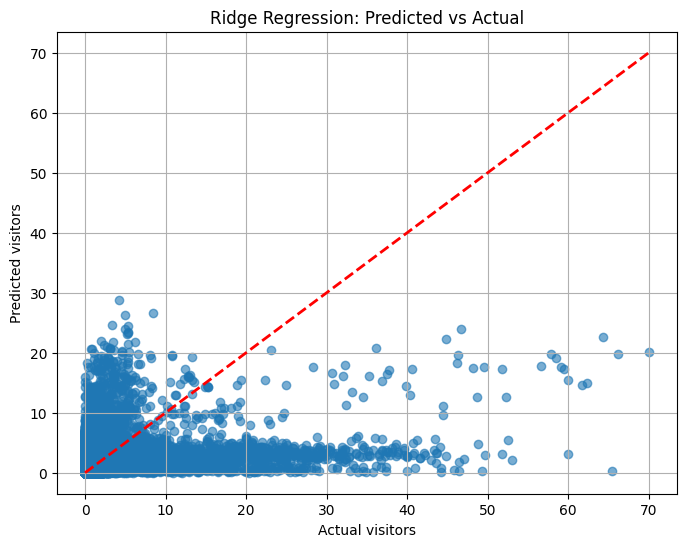

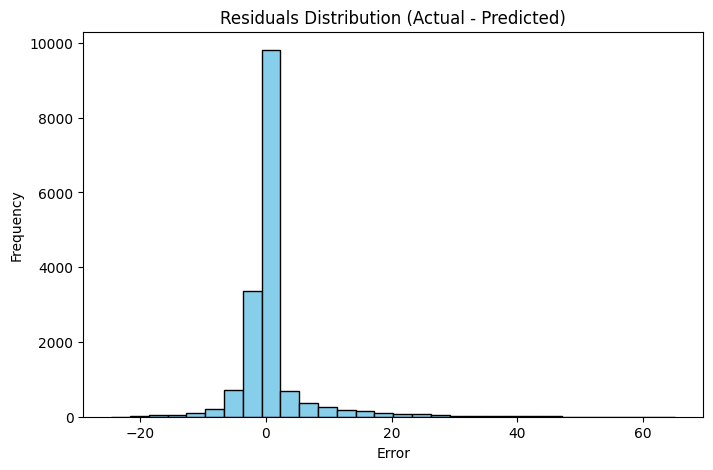

           category  importance  percentage
0  Vessel proximity    3.210237   77.142109
1           Weather    0.951222   22.857891


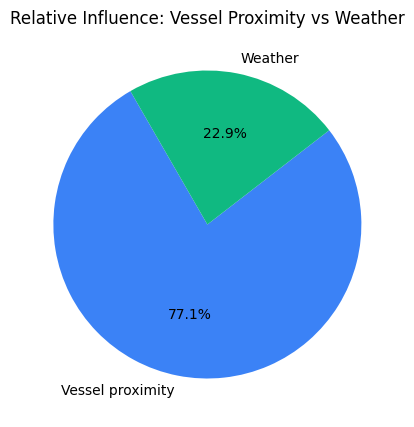

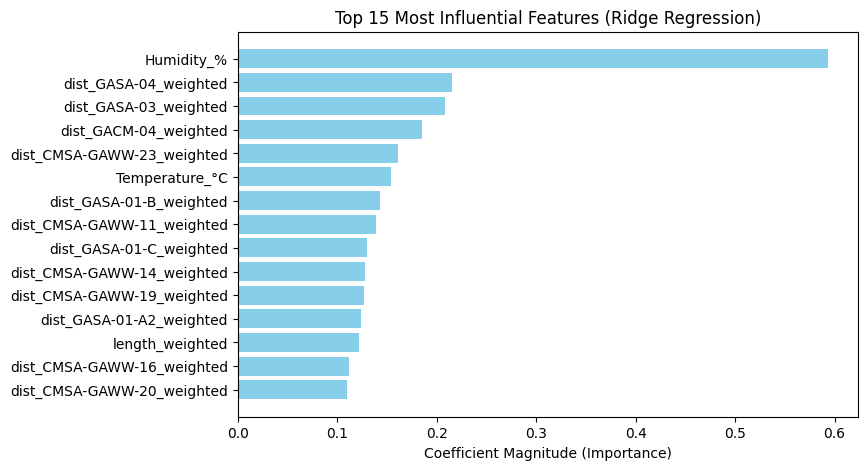

In [64]:
##Visuals

# Compare to your test data (after inverse_transform)
sample_preds = model.predict(X_test[:5])
print("Sample predictions:", sample_preds)
print("Corresponding actuals:", y_test[:5])

# Evaluate performance 
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, preds)

print("✅ Ridge Model Results")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Optional: Compare average predictions ---
print("\n--- Mean Comparison ---")
print(f"Train target mean: {y_train.mean():.2f}")
print(f"Test  target mean: {y_test.mean():.2f}")
print(f"Pred  mean:        {preds.mean():.2f}")

# --- Visualization ---
plt.figure(figsize=(8,6))
plt.scatter(y_test.flatten(), preds.flatten(), alpha=0.6)
plt.xlabel("Actual visitors")
plt.ylabel("Predicted visitors")
plt.title("Ridge Regression: Predicted vs Actual")
plt.grid(True)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.show()

# --- Residual plot ---
plt.figure(figsize=(8,5))
residuals = y_test.flatten() - preds.flatten()
plt.hist(residuals, bins=30, color='skyblue', edgecolor='k')
plt.title("Residuals Distribution (Actual - Predicted)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()

# --- Extract coefficients ---
ridge_model = model.regressor_.named_steps["ridge"]
coefs = ridge_model.coef_

# If multi-output (one model per CMSA column), average them
if coefs.ndim > 1:
    coefs_mean = np.mean(np.abs(coefs), axis=0)
else:
    coefs_mean = np.abs(coefs)

coef_df = pd.DataFrame({
    "feature": feature_cols,
    "importance": coefs_mean
})

# --- Separate into categories ---
coef_df["category"] = np.where(
    coef_df["feature"].str.startswith("dist_"),
    "Vessel proximity",
    "Weather"
)

# --- Aggregate contribution by category ---
cat_summary = (
    coef_df.groupby("category")["importance"]
    .sum()
    .reset_index()
    .sort_values("importance", ascending=False)
)

# --- Normalize to percentage ---
cat_summary["percentage"] = 100 * cat_summary["importance"] / cat_summary["importance"].sum()

print(cat_summary)

# --- Pie chart for overall contribution ---
plt.figure(figsize=(5,5))
plt.pie(
    cat_summary["percentage"],
    labels=cat_summary["category"],
    autopct="%1.1f%%",
    startangle=120,
    colors=["#3b82f6", "#10b981"]
)
plt.title("Relative Influence: Vessel Proximity vs Weather")
plt.show()

# --- Bar chart for top individual features ---
top_features = (
    coef_df
    .sort_values("importance", ascending=False)
    .head(15)
)

plt.figure(figsize=(8,5))
plt.barh(top_features["feature"], top_features["importance"], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Coefficient Magnitude (Importance)")
plt.title("Top 15 Most Influential Features (Ridge Regression)")
plt.show()
